# This notebook is a used for preliminary data exploration 

Data preprocessing:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Cleaning weather data

In [18]:
# Define cleaning function to clean weather data
def clean_weather_data(weather_path):
    # clean on weather dataframe
    df = pd.read_csv(weather_path)
    Hour = df['Hour (PST)'].apply(str)
    i=0
    for hour in Hour:
        if len(hour)<4:
            hour='0'+hour
        if hour[:2] == '24':
            hour = '0000'
        hour = hour[:2]+':'+hour[2:]+':00'
        Hour[i] = hour
        i+=1
    
    # Cleaning up datetime
    df['Date'] = df['Date'].str.replace('/', '-')
    df['Datetime'] = df['Date'] + ' '+Hour
    df.drop('Date', axis=1, inplace=True)
    df.drop('Hour (PST)', axis=1, inplace=True)
    df.drop('Day of the Year', axis=1, inplace=True)
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))
    df.drop('Datetime', axis=1, inplace=True)
    
    # Calculate vapor pressure deficit
    Te = df['Air Temp (C)'].to_numpy()
    RH = df['Rel Hum (%)'].to_numpy()
    df['Vapor pressure deficit (Pa)'] = (5.018+0.32321*Te+8.1847e-3*Te**2+3.1243e-4*Te**3)*(100-RH)/100
    
    # Some parameters to consider dropping
    df.drop('Wind Dir (0-360)', axis=1, inplace=True)
    df.drop('Soil Temp (C)', axis=1, inplace=True)
  
    return df

Cleaning microtensiometer data & down sampling 

In [19]:
# Clean tensiometer data:
def clean_mt_data(mT_path):
    df = pd.read_csv(mT_path)
    col_name = 'Averaged reading '+mT_path.rsplit('\\', 1)[-1]
    df = df.set_index(pd.DatetimeIndex(df['Human readable date']))
    df[col_name] = df.iloc[:,1:3].mean(axis = 1)
    df.drop(df.columns[[0,1,2,3]],axis=1,inplace = True)
    return df

# Down sample data in tighter time interval to match dataframe, by default resample to hourly data
def down_sample_df(df, period='H'):
    return df.resample(period).mean()

Exploratory data analysis

In [20]:
# path to read the weather data:
weather_path = r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\Napa_weather_data.csv'
# path to read the microtensiometer data:
mT_path_1 =  r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\M36_grape.csv'
mT_path_2 =  r'C:\Users\hl943\Documents\personal documents\data science\Insight DS\project directory\M37_grape.csv'

# Get weather dataframe
df_weather = down_sample_df(clean_weather_data(weather_path))
df_mt1 = down_sample_df(clean_mt_data(mT_path_1))
df_mt2 = down_sample_df(clean_mt_data(mT_path_2))
df_data = df_weather.join(df_mt1)
df_data = df_data.join(df_mt2)
df_data = df_data.dropna()


In [21]:
df_data.head()

,ETo (mm),Precip (mm),Sol Rad (W/sq.m),Vap Pres (kPa),Air Temp (C),Rel Hum (%),Dew Point (C),Wind Speed (m/s),Vapor pressure deficit (Pa),Averaged reading M36_grape.csv,Averaged reading M37_grape.csv
Datetime,,,,,,,,,,,
2019-06-05 18:00:00,0.28,0.0,259.0,2.1,29.4,51.0,18.3,3.7,14.471871,-0.03,0.0
2019-06-05 19:00:00,0.17,0.0,138.0,1.9,26.8,54.0,16.7,4.2,11.763359,-0.03,0.0
2019-06-05 20:00:00,0.07,0.0,14.0,1.7,23.2,60.0,15.0,4.0,8.329268,-0.04,0.0
2019-06-05 21:00:00,0.04,0.0,0.0,1.6,20.6,65.0,13.9,4.0,6.258207,-0.04,0.0
2019-06-05 22:00:00,0.03,0.0,0.0,1.5,19.0,70.0,13.4,3.8,4.876987,-0.04,0.0


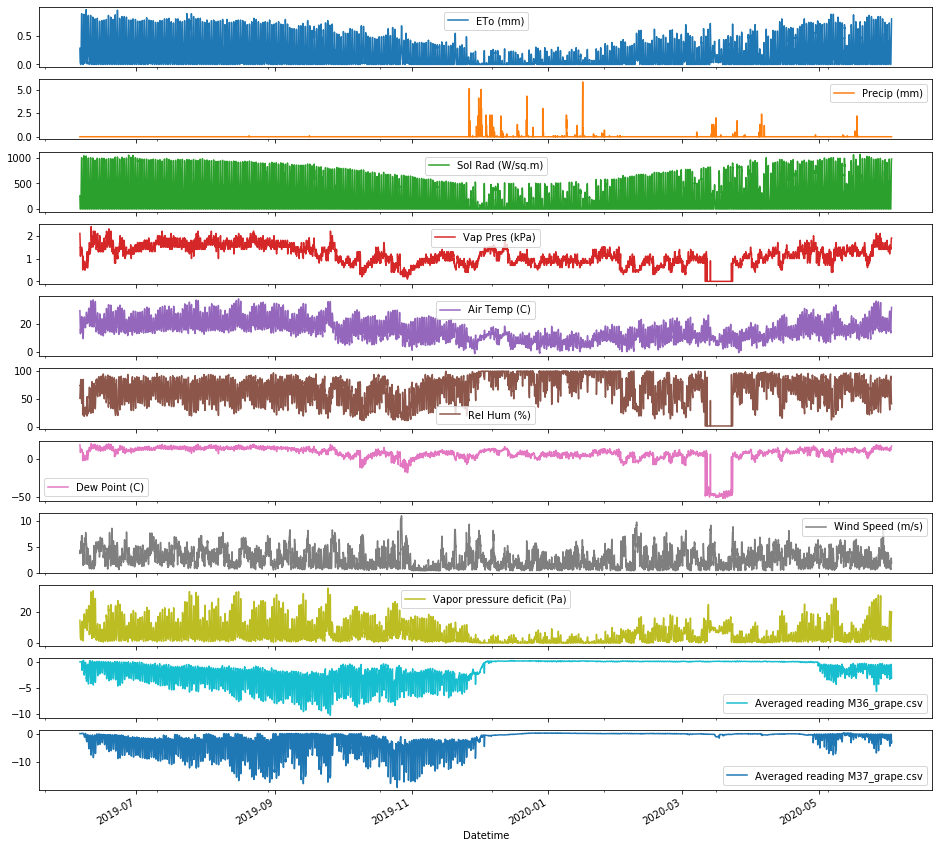

In [22]:
# plot some data
df_data.plot(subplots=True, layout=(len(df_train.columns), 1), figsize=(16, 16), sharex=True);

## some observations from plots ##

1. The bulk of precipitation take place outside of growing seasons, thus it seemed that the natural precipitation does not play an important role in informing irrigation.

2. The off season with no growth, may exclude it. 

3. ET and solar radiation look similar, maybe only one feature is needed

4. The two mT readings has some variations not sure what to look at first

5. Think about making prediction with daily Max. vs hourly data.

6. There are long term trend of the season annually

7. One entire growing season should be a good time period to build a predictive model


# More data cleaning and feature engineering

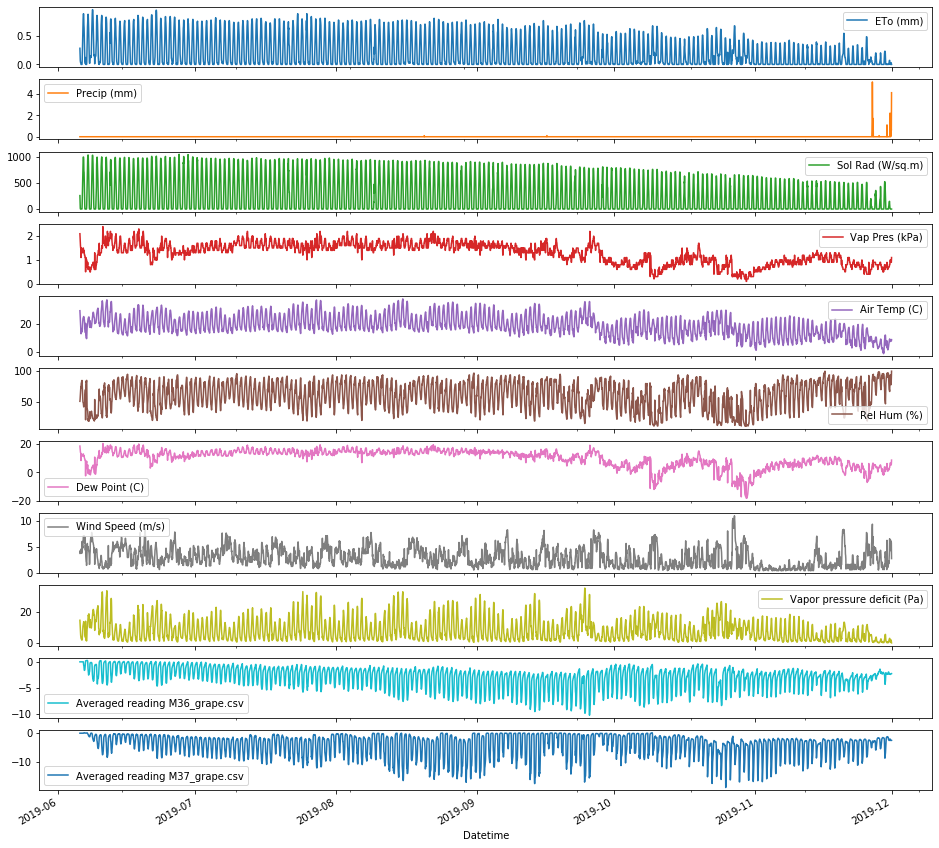

In [33]:
# defining the features and labels
start = '2019-06-01 00:00:00'
end = '2019-12-01 00:00:00'
df_data_2019 = df_data[start:end]
df_data[start:end].plot(subplots=True, layout=(len(df_train.columns), 1), figsize=(16, 16), sharex=True);

# Autoregressive model

EDA:

In [54]:
# Dickey-Fuller test, source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=24.0):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

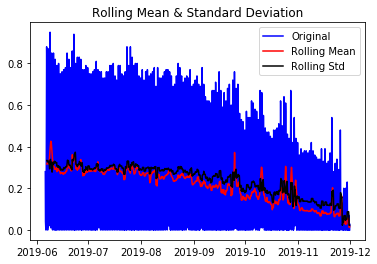

Results of Dickey-Fuller Test:
Test Statistic                   -3.176302
p-value                           0.021398
#Lags Used                       31.000000
Number of Observations Used    4235.000000
Critical Value (1%)              -3.431895
Critical Value (5%)              -2.862223
Critical Value (10%)             -2.567133
dtype: float64
ETo (mm)


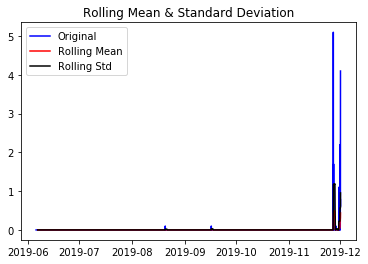

Results of Dickey-Fuller Test:
Test Statistic                   -5.129885
p-value                           0.000012
#Lags Used                       26.000000
Number of Observations Used    4240.000000
Critical Value (1%)              -3.431893
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Precip (mm)


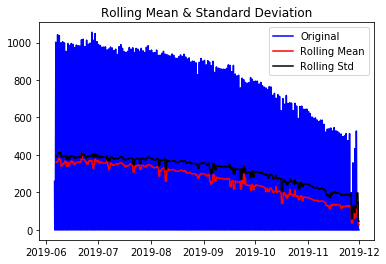

Results of Dickey-Fuller Test:
Test Statistic                   -0.677181
p-value                           0.852572
#Lags Used                       29.000000
Number of Observations Used    4237.000000
Critical Value (1%)              -3.431894
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Sol Rad (W/sq.m)


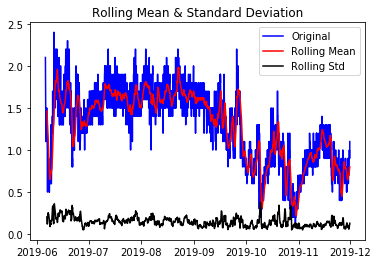

Results of Dickey-Fuller Test:
Test Statistic                   -3.241247
p-value                           0.017718
#Lags Used                       27.000000
Number of Observations Used    4239.000000
Critical Value (1%)              -3.431894
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Vap Pres (kPa)


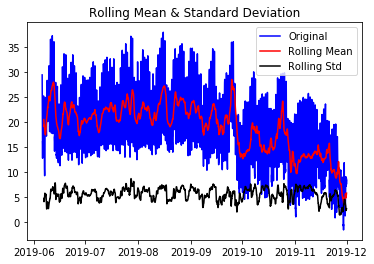

Results of Dickey-Fuller Test:
Test Statistic                   -2.619110
p-value                           0.089112
#Lags Used                       26.000000
Number of Observations Used    4240.000000
Critical Value (1%)              -3.431893
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Air Temp (C)


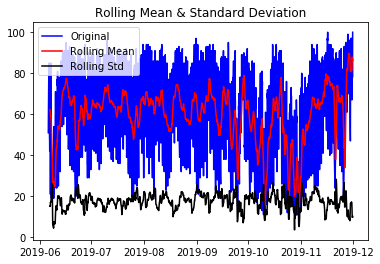

Results of Dickey-Fuller Test:
Test Statistic                -6.216777e+00
p-value                        5.342065e-08
#Lags Used                     2.900000e+01
Number of Observations Used    4.237000e+03
Critical Value (1%)           -3.431894e+00
Critical Value (5%)           -2.862222e+00
Critical Value (10%)          -2.567133e+00
dtype: float64
Rel Hum (%)


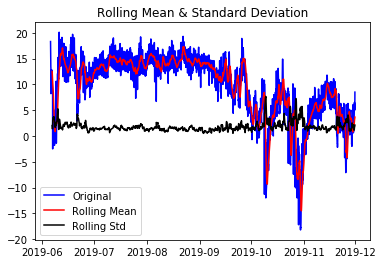

Results of Dickey-Fuller Test:
Test Statistic                   -3.798304
p-value                           0.002925
#Lags Used                       27.000000
Number of Observations Used    4239.000000
Critical Value (1%)              -3.431894
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Dew Point (C)


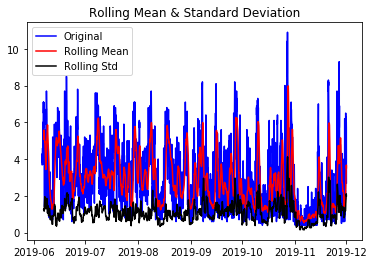

Results of Dickey-Fuller Test:
Test Statistic                -9.293546e+00
p-value                        1.162363e-15
#Lags Used                     2.700000e+01
Number of Observations Used    4.239000e+03
Critical Value (1%)           -3.431894e+00
Critical Value (5%)           -2.862222e+00
Critical Value (10%)          -2.567133e+00
dtype: float64
Wind Speed (m/s)


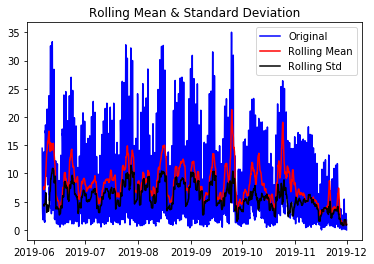

Results of Dickey-Fuller Test:
Test Statistic                   -5.529536
p-value                           0.000002
#Lags Used                       26.000000
Number of Observations Used    4240.000000
Critical Value (1%)              -3.431893
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Vapor pressure deficit (Pa)


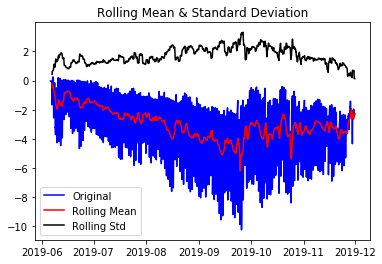

Results of Dickey-Fuller Test:
Test Statistic                   -3.397619
p-value                           0.011040
#Lags Used                       25.000000
Number of Observations Used    4241.000000
Critical Value (1%)              -3.431893
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Averaged reading M36_grape.csv


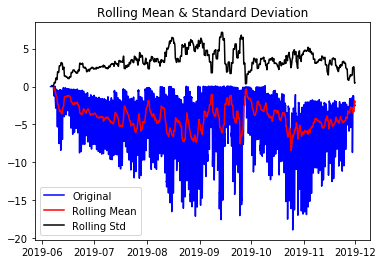

Results of Dickey-Fuller Test:
Test Statistic                   -4.944617
p-value                           0.000029
#Lags Used                       26.000000
Number of Observations Used    4240.000000
Critical Value (1%)              -3.431893
Critical Value (5%)              -2.862222
Critical Value (10%)             -2.567133
dtype: float64
Averaged reading M37_grape.csv


In [62]:
# Implement autoregressive model 
for i in range(len(df_data_2019.columns)):
    test_stationarity(df_data_2019.iloc[:,i], 24)
    print(df_data_2019.columns[i])


## Some observations:

1. Solar radiation and ET are clearly varying on daily/bi-daily basis. 
2. solar radiation alone does not predicts the stress level of a plant. 
3. The structure of the moving average in the sensor readings are some what reflected in VPD
4. Given solar radiation and ETo is not stationary while the plant stress is, this seems to indicate the plants can adjust itself over the long run to balance its stress level (for example, leaf falling, fruit bearing, etc.)


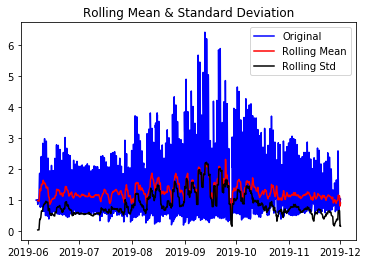

Results of Dickey-Fuller Test:
Test Statistic                -6.310173e+00
p-value                        3.249196e-08
#Lags Used                     2.500000e+01
Number of Observations Used    4.241000e+03
Critical Value (1%)           -3.431893e+00
Critical Value (5%)           -2.862222e+00
Critical Value (10%)          -2.567133e+00
dtype: float64
Averaged reading M37_grape.csv


In [76]:
# Implement autoregressive model 
   
# log transformed time series 
ts_log = np.log(-df_data_2019.iloc[:,-1]+1)
expweighted_avg = ts_log.ewm(24).mean()  
test_stationarity(np.exp(ts_log-expweighted_avg), 24)
print(df_data_2019.columns[-1])

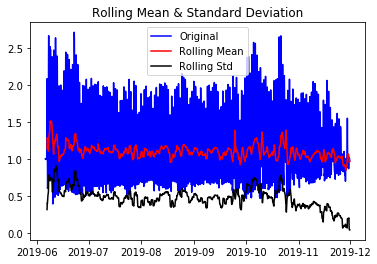

Results of Dickey-Fuller Test:
Test Statistic                -7.730028e+00
p-value                        1.131856e-11
#Lags Used                     2.900000e+01
Number of Observations Used    4.237000e+03
Critical Value (1%)           -3.431894e+00
Critical Value (5%)           -2.862222e+00
Critical Value (10%)          -2.567133e+00
dtype: float64
Averaged reading M36_grape.csv


In [75]:
# log transformed time series 
ts_log = np.log(-df_data_2019.iloc[:,-2]+1)
expweighted_avg = ts_log.ewm(24).mean()  
test_stationarity(np.exp(ts_log-expweighted_avg), 24)
print(df_data_2019.columns[-2])

### Some more observations on the tensiometer readings:
1. The long term trend of the mT readings are somewhat stationary after log transform. 
2. However the short term trends are probably not predictable by this long term trend. 

# Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Training/testing split for time series data 

In [ ]:
# train/test split
def train_test_split(X,Y, split_size):
    asset(X.shape[0]==Y.shape[0])
    n = X.shape[0]
    n_tr = np.ceil(n*split_size)
    Xtr = X[:n_tr,:]
    Xte = X[n_tr+1:,:]
    Ytr = Y[:n_tr,:]
    Yte = Y[n_tr+1:,:]
    return Xtr, Xte, Ytr, Yte

# since data is time dependent, do not randomize
split_size = 0.7
Xtr, Xte, Ytr, Yte = train_test_split(X,Y,split_size)

#------------------------------------------------------------------------
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# LSTM

In [ ]:
# define input sequence
in_seq1 = (VD-SVD)[3000:5000]
in_seq2 = SLI[3000:5000]
out_seq = PM1[3000:5000]
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1,in_seq2, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
#---------------------------------------------------------------------------
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction

In [ ]:

in_seq1 = (VD-SVD)[start:end]
in_seq2 = SLI[start:end]
out_seq = PM1[start:end]
time=timeMsT[n_steps-1+start:end]
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1,in_seq2, out_seq))
# choose a number of time steps
n_steps = 10
# convert into input/output
X, y = split_sequences(dataset, n_steps)
Y=[]
for x in X:
    x_input = x
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    Y.append(yhat)
model
Y2=np.array(Y).flatten()
plt.plot(time,Y2)
plt.plot(time,PM1[n_steps-1+start:end])